# TEXT_ANALYTICS
Applying text analytics to understand the relationship/similarity between companies based on their patents (title and Abstract)

In [1]:
#imported packages
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd #to read Excel files
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string #to remove punctuation and digits
from glob import glob
from sklearn.cluster import KMeans

# Part A: Preprocess the data

In [2]:
#variables
stopwords = list(ENGLISH_STOP_WORDS)
#more stopwords can be added by using .append 
p = string.punctuation
d = string.digits
combined = p + d

In [3]:
#variables
docs1 = []
company_names = [] 

In [4]:
#function
def func(txt):
    txt = txt.lower() #normalizing
    table = str.maketrans(combined, len(combined) * " ") #removing punc
    txt = txt.translate(table)
    words = txt.split()
    cleaned_words = [w for w in words if w not in stopwords] #removing stopwords
    cleaned_text = " ".join(cleaned_words) #cleaned text
    return cleaned_text
corpus = glob("Patents_xls/*xlsx") #reading file into corpus

In [5]:
#combined two columns AB and TI 
for c in corpus:
    df = pd.read_excel(c)
    df['AB'].dropna(inplace = True)
    df['TI'].dropna(inplace = True)
    df['joined_col'] = df.AB.str.cat(df.TI,sep=" ")
    combo = list (df['joined_col'])
    #title=list(df['TI'])
    combo_2 = ','.join([str(i) for i in combo])  
    #" ".join(abstracts)
    combo_f = func(combo_2)
    docs1.append(combo_f)
    name = c.split("/")[-1][:-5]
    company_names.append(name)

In [6]:
#lemmatization
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
lem_doc = []
for sentence in docs1:
    lem_doc.append(" ".join([wnl.lemmatize(i) for i in sentence.split()]))

In [7]:
#To get token's
import nltk
full_str = ' '.join([str(elem) for elem in lem_doc])
words = nltk.word_tokenize(full_str)
words[:10]
#type(words)

['method',
 'handling',
 'deferred',
 'location',
 'request',
 'including',
 'location',
 'service',
 'lcs',
 'client']

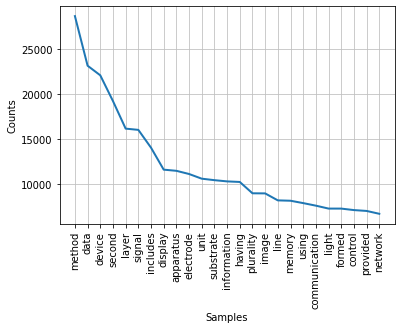

In [9]:
#frequent_words plot
word_frequencies = nltk.FreqDist(words)
word_frequencies.most_common(10)
word_frequencies.plot(25)

In [10]:
#word_count
from collections import Counter
c = Counter(words)
c.most_common(10)

[('method', 28640),
 ('data', 23139),
 ('device', 22072),
 ('second', 19217),
 ('layer', 16160),
 ('signal', 16022),
 ('includes', 14047),
 ('display', 11610),
 ('apparatus', 11480),
 ('electrode', 11127)]

In [11]:
#to get POS_Tags
from textblob import TextBlob
txt = TextBlob(full_str)
x=txt.words
y=txt.sentences
type(x)

textblob.blob.WordList

In [12]:
#x[:10]
#y[:1]

In [13]:
#Run to get pos_tags, takes more time to run so commented
#import nltk
#nltk.download('averaged_perceptron_tagger')
#z=txt.tags
#z[:10]

In [14]:
#after lemmatization
vectorizer = TfidfVectorizer()
sparse_matrix = vectorizer.fit_transform(lem_doc)
print(sparse_matrix.shape)

(13, 17181)


In [15]:
#converting to dense format
dense_matrix = sparse_matrix.todense()
tdm = dense_matrix.transpose()
print(tdm)

[[0.         0.         0.         ... 0.         0.00040381 0.        ]
 [0.00702699 0.         0.         ... 0.         0.00012584 0.00042258]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00020068 0.        ]
 [0.         0.         0.         ... 0.         0.00020068 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Part B
# Multidimensional Scaling

In [16]:
#imported packages and initiated
from sklearn.metrics.pairwise import cosine_similarity
vectorizer_MSD = TfidfVectorizer(stop_words = 'english', min_df = 2)
dtm1 = vectorizer.fit_transform(lem_doc)
similarity1 = cosine_similarity(dtm1)
cos_distance1 = 1 - similarity1
#print(cos_distance1)

In [17]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

In [18]:
mds = MDS(n_components = 2, dissimilarity='precomputed', random_state=1)
pos1 = mds.fit_transform(cos_distance1)
#print(pos1)

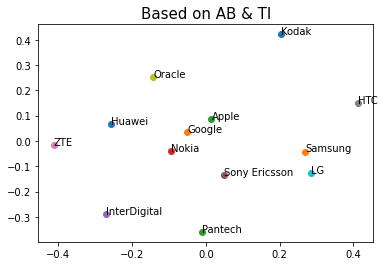

In [19]:
#plot MDS
plt.title("Based on AB & TI", size=15)
xs, ys = pos1[:,0], pos1[:,1]
for x, y, name in zip(xs, ys, company_names):
    plt.scatter(x, y)
    plt.text(x, y, name)
plt.show()

# Hierarchical Clustering (Dendrogram)

In [20]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix= ward(cos_distance1)

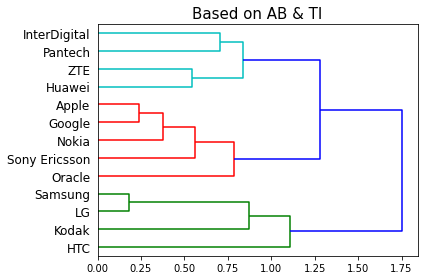

In [21]:
plt.title("Based on AB & TI", size=15)
dendrogram(linkage_matrix, orientation='right', labels=company_names)
plt.tight_layout()
plt.show()

In [22]:
#results

# K-Means

In [23]:
km = KMeans(n_clusters=4, random_state=999)
km.fit(sparse_matrix) #computes k-means clustering
cluster_membership = km.predict(sparse_matrix) #predicts closest cluster
company_distance_to_center = km.transform(sparse_matrix) #cluster distance
cluster_membership

array([2, 1, 3, 2, 2, 3, 2, 3, 1, 0, 0, 0, 1], dtype=int32)

In [24]:
print(company_distance_to_center)

[[0.94600271 0.72570399 0.46298555 0.85096156]
 [0.80576567 0.31564952 0.57830029 0.65642998]
 [0.97475304 0.90731234 0.77461792 0.56049955]
 [0.84289544 0.52552974 0.40341688 0.59550841]
 [1.01889665 0.87042947 0.61996453 0.89063808]
 [0.85976299 0.6938723  0.74584867 0.41187197]
 [1.04931115 0.89859615 0.53071304 0.91378724]
 [0.98438531 0.93756749 0.97257449 0.60869043]
 [0.94704115 0.41946552 0.77049057 0.90360875]
 [0.39109221 0.85187615 0.87442579 0.84478298]
 [0.56207218 0.95177852 1.04337997 0.99039381]
 [0.32854102 0.82273018 0.86583426 0.82844873]
 [0.75685125 0.33427579 0.67295406 0.68507089]]


In [25]:
#cluster for each company
clusters = zip(cluster_membership, company_names)
print("{0:<15s}{1:<9s}".format("Company_Names","Cluster"))
for cluster_number, company_name in clusters:
    print("{0:<15s}{1:2d}".format(company_name,cluster_number))

Company_Names  Cluster  
Huawei          2
Google          1
Pantech         3
Nokia           2
InterDigital    2
Sony Ericsson   3
ZTE             2
HTC             3
Oracle          1
LG              0
Kodak           0
Samsung         0
Apple           1


In [26]:
#fitting in dataframe
companies = {'Company': company_names, 'Cluster_Final': cluster_membership,\
            'Centroid_Dist0':company_distance_to_center[0:,0],\
            'Centroid_Dist1':company_distance_to_center[0:,1],\
            'Centroid_Dist2':company_distance_to_center[0:,2],\
            'Centroid_Dist3':company_distance_to_center[0:,3]
            }
#let us put this in a dataframe
import pandas as pd
df_km = pd.DataFrame(companies)
df_km

,Company,Cluster_Final,Centroid_Dist0,Centroid_Dist1,Centroid_Dist2,Centroid_Dist3
0,Huawei,2,0.946003,0.725704,0.462986,0.850962
1,Google,1,0.805766,0.315650,0.578300,0.656430
2,Pantech,3,0.974753,0.907312,0.774618,0.560500
3,Nokia,2,0.842895,0.525530,0.403417,0.595508
4,InterDigital,2,1.018897,0.870429,0.619965,0.890638
5,Sony Ericsson,3,0.859763,0.693872,0.745849,0.411872
6,ZTE,2,1.049311,0.898596,0.530713,0.913787
7,HTC,3,0.984385,0.937567,0.972574,0.608690
8,Oracle,1,0.947041,0.419466,0.770491,0.903609
9,LG,0,0.391092,0.851876,0.874426,0.844783


In [27]:
#plot K-means cluster
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

Text(0.5, 1.0, 'Based on AB & TI')

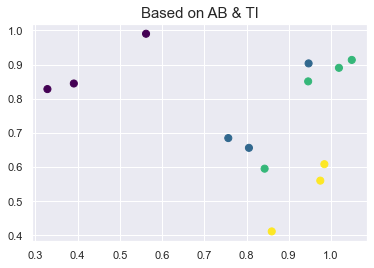

In [28]:
#plotted by taking best measures (distances out of 4)
plt.scatter(company_distance_to_center[0:,0], company_distance_to_center[0:,3], c=cluster_membership, s=50, cmap='viridis')
plt.title("Based on AB & TI", size=15)

- Comparatively Hierarchical Clustering and K-Means shows similar outputs, three out of four companies exibits similar results (by taking clusters=4 in K-Means)  
- When compared above two models with Multidimensional Scaling, results are not as same and similarity is less

# Part C
# NMF

In [29]:
#imported packages
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import glob
import os
from sklearn import decomposition

In [30]:
vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 2)

In [31]:
dtm = vectorizer.fit_transform(lem_doc)
vocab = vectorizer.get_feature_names() 
names = [fn[:-4] for fn in corpus]

In [32]:
num_topics = 5
num_top_words = 20
clf = decomposition.NMF(n_components = num_topics, random_state=1)
doctopic = clf.fit_transform(dtm)
topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [33]:
print("Getting results: 5 topics")
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Getting results: 5 topics
Topic 0: data method device user network second information application object includes based embodiment set associated memory
Topic 1: image electrode layer method second device data light display substrate includes having pixel apparatus liquid
Topic 2: device second unit electronic remote host nan body plurality circuit portable antenna communication tone method
Topic 3: communication mobile terminal data signal method channel device information unit wireless having antenna power station
Topic 4: method network service signal invention control packet present data communication device gateway terminal message user


# LDA

In [34]:
#imported packages
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words='english')
num_topics = 5
dtm = vectorizer.fit_transform(lem_doc)

In [35]:
lda = LatentDirichletAllocation(n_components=num_topics, learning_method="batch",  max_iter=2000, random_state=0)

In [36]:
#takes time than usual to run
document_topics = lda.fit_transform(dtm)

In [37]:
feature_names = vectorizer.get_feature_names()

In [38]:
def display_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
print("Getting results: 5 topics")
display_topics(lda, feature_names, 20)

Getting results: 5 topics
Topic 0:
image electronic message display element antenna received provided content said packet frame nan associated location receiver portable computer video audio
Topic 1:
image layer color material light printing element pixel substrate camera sensor surface ink liquid imaging group display region charge electrode
Topic 2:
application node object embodiment associated database message computer client packet file query provided storage code document web instruction provides multiple
Topic 3:
display electrode layer substrate line liquid crystal pixel gate recording light panel provided film region area driving surface image optical
Topic 4:
layer electrode substrate semiconductor display light line image region gate pattern provided forming surface transistor pixel film source area panel


# LSA/LSI

In [39]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9,stop_words='english', lowercase=True)
data_vectorized = vectorizer.fit_transform(lem_doc)

In [41]:
def get_topics(model, vectorizer, model_name, dff, top_n = 20):
        result = []
        for idx, topic in enumerate(model.components_): 
            print("Topic %d:" % (idx))
            topic_label = model_name + "_topic_" + str(idx)            
            score = "SCORE_" + str(idx)
            aList = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
            l1, l2 = zip(*aList)
            dff[topic_label] = l1
            dff[score] = l2
            print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-top_n - 1:-1]]))
        return dff

In [42]:
print("Getting results: 5 topics and scores") 
lsi_model = TruncatedSVD(n_components=5, n_iter = 5000)
lsi_Z = lsi_model.fit_transform(data_vectorized)
get_topics(lsi_model, vectorizer, "LSI", pd.DataFrame())

Getting results: 5 topics and scores
Topic 0:
cellular current exchanged complex dispose firewire colorants framing dipping cutout binarized fa carry convolution chamfered feeding electroactive decided amplifying diagnostic
Topic 1:
cutout binarized electroactive dispose cellular dipping actual altered diagnostic dispersing greatest asynchronously carry date byte crystallinity demanded capture colorants announcement
Topic 2:
destroys colloidal asked dvd capillary centerline cl fpc conveyed decrement groove dpd drug course fb gradually clear fc forbidden apl
Topic 3:
centerline deployment adjustable competition exclude applet distributing decoupled frequently assure capillary fe announcement arbitrating chroma complexity advisor course bezel assistance
Topic 4:
capillary doubling decomposes assure exclude applet dvd dispose dose convection current communicable double approached consistency arithmetically cart distorted approaching exhibited


,LSI_topic_0,SCORE_0,LSI_topic_1,SCORE_1,LSI_topic_2,SCORE_2,LSI_topic_3,SCORE_3,LSI_topic_4,SCORE_4
0,electrode,0.445399,liquid,0.397482,object,0.301837,element,0.320665,document,0.285954
1,light,0.285574,crystal,0.388335,file,0.211373,nan,0.204582,printing,0.230323
2,semiconductor,0.282730,recording,0.264082,client,0.177276,antenna,0.200211,material,0.225441
3,gate,0.249059,pixel,0.172276,query,0.154029,frame,0.190366,color,0.222495
4,pixel,0.187619,electrode,0.134507,document,0.152905,sensor,0.150335,sensor,0.205354
5,surface,0.166164,panel,0.112701,element,0.143441,camera,0.128434,camera,0.180755
6,film,0.164249,air,0.101152,event,0.137689,portable,0.124188,query,0.146797
7,transistor,0.152432,battery,0.099087,transaction,0.137143,mean,0.122893,pixel,0.146141
8,panel,0.147886,optical,0.090385,instruction,0.133899,transmitter,0.103456,print,0.142966
9,liquid,0.146021,picture,0.086575,mechanism,0.132988,color,0.097731,ink,0.142332


- By comparing all three NMF, LSA and LDA: results obtained are way different from each other and similarity is very less.
- Additionally by Observing deep, in between the topics there is better similarity
    - example: panel with score 0.147886 in LSI_topic_0 and 0.112701 in LSI_topic_1	
- Scores for LSA is printed above
-  NOTE: Number of words for topics can be changed in models above.